In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

### Data preparation
The data in this dataset come from a real-world admissions board for a large high school district.  The district runs several specialized programs for which they run admissions.  As such, the data is taken from spreadsheets created over the course of 10 years.  As such, column names, admissions criteria used and data maintained over the years has changed. This initial data preparation involves getting the original data into a consistent format.  There will be no data manipulation or analysis conducted at this stage.

In [3]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import os
import glob
import re

import missingno as msno

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import set_config
from missingpy import MissForest

%matplotlib inline

In [4]:
'''Import all csv files in active folder and create dictionary of dataframes'''
csv_files = glob.glob('*.csv')

var_dict = {}

for file in csv_files:
    key = 'df_'+str(re.split('.csv', file)[0])
    value = pd.read_csv(file)
    var_dict[key] = value

In [ ]:
'''Update global variable table and create individual dataframes'''
'''globals().update(var_dict)

df_list = []
for key, value in var_dict.items():
    print(key,value)'''

In [5]:
'''List of all dataframes'''
var_dict.keys()

dict_keys(['df_2008_2009_ib_magnet', 'df_2009_2010_ib', 'df_2009_2010_magnet', 'df_2010-2011_ib', 'df_2010-2011_magnet', 'df_2011_2012_in_district', 'df_2011_2012_out_district', 'df_2012_2013_in_district', 'df_2012_2013_out_district', 'df_2013_2014_in_district', 'df_2013_2014_out_district', 'df_2014_2015_in_district', 'df_2014_2015_out_district', 'df_2015_2016_in_district', 'df_2015_2016_out_district', 'df_2016_2017_in_district', 'df_2016_2017_out_district', 'df_2017_2018_in_district', 'df_2017_2018_out_district', 'df_2018_2019_in_district', 'df_2018_2019_out_district', 'df_2019_2020_in_district', 'df_2019_2020_out_district', 'df_2020_2021_in_district', 'df_2020_2021_out_district', 'df_2021_2022_in_district', 'df_2021_2022_out_district'])

In [6]:
var_dict['df_2008_2009_ib_magnet'].columns

Index(['CL', 'L.N', 'F.N', 'ID', 'Sending District', 'Middle School', 'OHS',
       'Math Course', 'G', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW',
       'P.I.Score', 'IN', 'INC', 'INW', 'Admit Score', 'Decision',
       'Accepted Offer?', 'Reception Letter Sent', 'Reception RSVP',
       'Withdrew  in first year', 'Reason', 'GPA 1st year'],
      dtype='object')

In [7]:
'''List of columns to drop from original files'''
drop_columns = ['Record Created Date', '#', 'Sibling', 'NYr Grade', 'Also GHS', 'Tier', 'DOB', 'Address', 'City', 'State',\
                'ZIP', 'Home Phone', 'Work/Cell Phone', 'Parent email', 'ID', 'District of Residence', 'Sending District',\
               'Current School', 'Middle School', 'Current School', 'Current Grade', 'Grade Level', 'OHS', 'Academy?',\
               'Academy', 'Math Course', 'Gender', 'G', 'Foreign Language', 'Length', 'IEP?', 'IEP/ISP', 'IEP', '504?',\
               '504', '7th Grade Math', '7th Grade Sci', '7th Grade Eng', '7th Grade SS', '7th Grade WL', '8th Grade Math',\
               '8th Grade Sci', '8th Grade Eng', '8th Grade SS', '8th Grade WL', 'Transcripts', 'Transcript', 'Transcript?',\
               'Attendance?', 'Attendance', 'Discipline?', 'Discipline', 'Tests?', 'Recommendations', 'Recs', 'Rec',\
               'Notes', 'Notes', 'Notes.1', 'Notes.2' 'Math/Sci Rec', 'Math/Sci Adv Course', 'Eng/SS Adv Course', 'Adv Courses',\
               'Waitlist #', 'WL #', 'Withdrew  in first year', 'Withdrew', 'Reason', 'Acc Sp.', 'Acc Sp Gr', 'GPA 1st year',\
               'Prediction', 'Student email', 'Requested HS', 'Sending Supt.', 'Preference', 'Info Release consent',\
               'Tuition Code', 'Reception Letter Sent', 'Reception RSVP', 'Testing Number', 'Ethnic', 'Unnamed: 49', \
               'Unnamed: 53', 'Unnamed: 52', 'Prospect Street', 'Prospect City', 'Prospect State', 'Prospect Zip', \
               'Resident District', 'Filler', 'MCST Academy', 'P.I.Score', 'PI Score', 'AX Offer?.1', 'Car Pooling info',\
               'Unnamed: 59', 'Unnamed: 60', 'Eng/SS Rec', 'Math/Sci Rec', 'Math/Sci Adv', 'Eng/SS Adv', 'Adv. Courses', \
               'Parent/Guardian Name']

drop_columns = [column.lower() for column in drop_columns]

In [8]:
'''Drop unnecessary columns from original data'''
for key, item in var_dict.items():
    for column in item.columns:
        column_lower = column.strip().lower()
        if column_lower in drop_columns:
            item.drop(column, axis=1, inplace = True)

In [9]:
var_dict['df_2008_2009_ib_magnet'].columns

Index(['CL', 'L.N', 'F.N', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW', 'IN',
       'INC', 'INW', 'Admit Score', 'Decision', 'Accepted Offer?'],
      dtype='object')

In [10]:
'''Create list of all columns'''
column_list = []
for key,item in var_dict.items():
    column_list.append(item.columns)
column_list

[Index(['CL', 'L.N', 'F.N', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
        'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW', 'IN',
        'INC', 'INW', 'Admit Score', 'Decision', 'Accepted Offer?'],
       dtype='object'),
 Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
        'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
        'RCC', 'RCW', 'PIScore', 'IN', 'INC', 'INW', 'Admit Score',
        'Admit Status', 'Attending?'],
       dtype='object'),
 Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
        'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
        'RCC', 'RCW', 'IN', 'INC', 'INW', 'Admit Score', 'Admit Status',
        'Attending?'],
       dtype='object'),
 Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
        'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
        'RCC', 'RCW', 'IN'

In [11]:
'''Dictionary to standardize column names'''
rename_dict = {'CL': 'program',
               'Program': 'program',
               'L.N': 'last_name', 'Last Name': 'last_name',
               'F.N': 'first_name', 'First Name': 'first_name',
               'ES': 'essay_raw', 'WP': 'essay_raw', 'ACC Score Raw': 'essay_raw',
               'ESC': 'essay_converted', 'WPC': 'essay_converted', 'ACC C': 'essay_converted', 
               'ESW': 'essay_weighted', 'WPW': 'essay_weighted', 'ACC W': 'essay_weighted',
               'ME': 'math_raw', 'AR': 'math_raw',
               'MEC': 'math_converted', 'ARC': 'math_converted', 
               'MEW': 'math_weighted', 'ARW': 'math_weighted', 
               'GP': 'gpa_raw', 'GPA': 'gpa_raw',
               'GPC': 'gpa_converted', 'GPAC': 'gpa_converted',
               'GPW': 'gpa_weighted', 'GPAW': 'gpa_weighted', 
               'STE': 'standard_ela',
               'STEC': 'standard_ela_converted',
               'STEW': 'standard_ela_weighted',
               'STM':  'standard_math',
               'TOTAL': 'standard_total',  
               'STC': 'standard_total_converted', 
               'STW': 'standard_total_weighted',
               'RD': 'reading_score_raw',
               'RDC': 'reading_score_converted',
               'RDW': 'reading_score_weighted',
               'EA': 'qas', 'QAS': 'qas',
               'EAC': 'qas_converted', 'QASC': 'qas_converted',
               'EAW': 'qas_weighted', 'QASW': 'qas_weighted',         
               'RC': 'recommend', 'Rec': 'recommend', 
               'RCC': 'recommend_converted', 
               'RCW': 'recommend_weighted', 'RecW': 'recommend_weighted', 'RECW': 'recommend_weighted',
               'IN': 'interview', 
               'INC': 'interview_converted', 
               'INW' : 'interview_weighted', 
               'Admit Score': 'admit_score', 'Total': 'admit_score',
               'Decision': 'admit_decision', 'Admit Status': 'admit_decision', 'Accepted Offer?': 'admit_decision', 'Status': 'admit_decision',
               'Accepted Offer?': "admit_offer_accepted", 'AX Offer?': "admit_offer_accepted", 'Attending?': "admit_offer_accepted"
}

In [12]:
'''Standardize Column Names'''
drop_names = ['last_name', 'first_name', 'Name']

for key,item in var_dict.items():
    item.rename(columns = rename_dict, inplace = True)
    for column in item.columns:
        if column in drop_names:
            item.drop(column, axis = 1, inplace = True)
    print(key,":", item.columns)

df_2008_2009_ib_magnet : Index(['program', 'essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total',
       'standard_total_converted', 'standard_total_weighted', 'recommend',
       'recommend_converted', 'recommend_weighted', 'interview',
       'interview_converted', 'interview_weighted', 'admit_score',
       'admit_decision', 'admit_offer_accepted'],
      dtype='object')
df_2009_2010_ib : Index(['program', 'essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total',
       'standard_total_converted', 'standard_total_weighted', 'recommend',
       'recommend_converted', 'recommend_weighted', 'PIScore', 'interview',
       'interview_converted', 'interview_weighted', 'admit_score',
       'admi

In [13]:
'''Find unique values in each column'''
unique_check = ['program', 'admit_decision', 'admit_offer_accepted']

for key,item in var_dict.items():
    print("\n",key)
    for column in item:
        if column in unique_check:
            print(column, item[column].unique())


 df_2008_2009_ib_magnet
program ['Magnet' 'IB']
admit_decision ['RJ' 'WD-ACAD' 'AX' nan 'WD']
admit_offer_accepted [nan 'Y' 'No-Academy' 'No-IB' 'No-Magnet']

 df_2009_2010_ib
program ['IB' 'Both' nan]
admit_decision ['AX' 'RJ' nan]
admit_offer_accepted ['yes' nan 'no']

 df_2009_2010_magnet
program ['Magnet' 'Both' nan]
admit_decision ['AX' 'AX ' 'RJ' 'W/D' nan]
admit_offer_accepted ['no-Academy' 'yes' 'no--Academy' 'no'
 'no--attending Health Acad per Michele' 'yes ' 'yes--AX late' nan]

 df_2010-2011_ib
program ['Both' 'IB' nan]
admit_decision ['AX' 'CAX' 'RET' 'RJ' 'missing rec' 'no interview' nan]
admit_offer_accepted ['yes' 'no' nan]

 df_2010-2011_magnet
program ['Magnet' 'Both' nan 'Total Applicants:  29 (25)'
 'Total Applicants 70 or higher: 17 (18)'
 'Average Admit Score: 69.1 (73.7)' 'Median Admit Score: 71.5 (76.4)'
 'AX rate: 55%']
admit_decision ['AX' 'CAX' 'RJ' 'RET?' nan]
admit_offer_accepted ['yes' 'no--Academy' 'no' 'yes--ax late' nan]

 df_2011_2012_in_district
prog

In [14]:
'''Drop empty and non-IB/magnet rows'''
for key,item in var_dict.items():
    item.dropna(axis = 0, thresh = 12, inplace = True)
    item.dropna(axis = 0, subset = ['program'], inplace=True)
    print(key, item)
    #item = item[item['program'] != 'Regular']

df_2008_2009_ib_magnet    program  essay_raw  essay_converted  essay_weighted  math_raw  \
0   Magnet        4.5               75             4.5      27.0   
1   Magnet        5.0               80             4.8      36.0   
2   Magnet        5.0               80             4.8      88.0   
3   Magnet        5.0               80             4.8      85.0   
4   Magnet        4.0               70             4.2      69.0   
..     ...        ...              ...             ...       ...   
83  Magnet        6.0              100             6.0      73.0   
84      IB        4.5               75             7.5      53.0   
85  Magnet        4.5               75             4.5      53.0   
86      IB        4.5               75             7.5      54.0   
87  Magnet        4.5               75             4.5      54.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0                0            0.0     95.0             80          16.0  ...   


df_2015_2016_in_district    program  essay_raw  essay_converted  essay_weighted  math_raw  \
0       IB       70.0             70.0             7.0      73.0   
1       IB       68.0             60.0             6.0      38.0   
3       IB       84.0             80.0             8.0      81.0   
4       IB       82.0             80.0             8.0      56.0   
5       IB       95.0            100.0            10.0     109.0   
..     ...        ...              ...             ...       ...   
90  Magnet       62.0              0.0             0.0      61.0   
91  Magnet       89.0             90.0             9.0      91.0   
92  Magnet       79.0             80.0             8.0      71.0   
93  Magnet       88.0             90.0             9.0     116.0   
94  Magnet       87.0             90.0             9.0     120.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0             80.0            4.0     92.0           80.0          12.0  ...  

df_2017_2018_in_district     program  math_raw  math_converted  math_weighted    qas  qas_converted  \
0        IB      93.0            80.0           12.0   97.0           90.0   
1        IB     103.0            90.0           13.5   60.0           70.0   
2        IB      91.0            80.0           12.0   69.0           80.0   
3        IB     108.0            90.0           13.5  108.0          100.0   
4        IB     117.0           100.0           15.0   94.0           90.0   
..      ...       ...             ...            ...    ...            ...   
110  Magnet      97.0            80.0           12.0   49.0            0.0   
111  Magnet     111.0            90.0           13.5   79.0           60.0   
112  Magnet     111.0            90.0           13.5   97.0           80.0   
113  Magnet     120.0           100.0           15.0   68.0           50.0   
114  Magnet     111.0            90.0           13.5   92.0           80.0   

     qas_weighted  reading_score_raw  

In [15]:
'''Correct program in certain dataframes'''
ib_list = ['df_2009_2010_ib', 'df_2010-2011_ib']
magnet_list = ['df_2009_2010_magnet', 'df_2010-2011_magnet']

for key,item in var_dict.items():
    if key in ib_list:
        item['program'] = 'IB'
    if key in magnet_list:
        item['program'] = 'Magnet'

In [16]:
'''Find unique values in each column'''
unique_check = ['program', 'admit_decision', 'admit_offer_accepted']

for key,item in var_dict.items():
    print("\n",key)
    for column in item:
        if column in unique_check:
            print(column, item[column].unique())


 df_2008_2009_ib_magnet
program ['Magnet' 'IB']
admit_decision ['RJ' 'WD-ACAD' 'AX' nan 'WD']
admit_offer_accepted [nan 'Y' 'No-Academy' 'No-IB' 'No-Magnet']

 df_2009_2010_ib
program ['IB']
admit_decision ['AX' 'RJ']
admit_offer_accepted ['yes' nan 'no']

 df_2009_2010_magnet
program ['Magnet']
admit_decision ['AX' 'AX ' 'RJ' 'W/D']
admit_offer_accepted ['no-Academy' 'yes' 'no--Academy' 'no'
 'no--attending Health Acad per Michele' 'yes ' 'yes--AX late' nan]

 df_2010-2011_ib
program ['IB']
admit_decision ['AX' 'CAX' 'RET' 'RJ' 'missing rec' 'no interview']
admit_offer_accepted ['yes' 'no' nan]

 df_2010-2011_magnet
program ['Magnet']
admit_decision ['AX' 'CAX' 'RJ' 'RET?']
admit_offer_accepted ['yes' 'no--Academy' 'no' 'yes--ax late' nan]

 df_2011_2012_in_district
program ['IB' 'Magnet']
admit_decision ['AX' 'RJ' 'DF']
admit_offer_accepted ['no' 'yes' 'late applicant'
 'student withdrew 2/28, AX to VoTech computer tech'
 'w/d-7/11 to attend Magnet' 'no-ax but w/d to attend Magnet 6

In [17]:
'''Standardize data'''
for key,item in var_dict.items():
    item['admit_decision'] = item['admit_decision'].apply(lambda x: 'ax' if 'ax' in str(x).lower() else 'rj'if ('rj' or 'ret' or 'df') in \
                                                          str(x).lower() else 'wd' if ('wd'or'w/d') in str(x).lower() else 'rj')
    item['admit_offer_accepted'] = item['admit_offer_accepted'].apply(lambda x: 'yes' if 'y' in str(x).lower() else 'no'if ('no' or 'n') in \
                                                          str(x).lower() else 'no')

In [18]:
'''Print cleaned and standardized dataframes'''
for key,item in var_dict.items():
    print(key, item)

df_2008_2009_ib_magnet    program  essay_raw  essay_converted  essay_weighted  math_raw  \
0   Magnet        4.5               75             4.5      27.0   
1   Magnet        5.0               80             4.8      36.0   
2   Magnet        5.0               80             4.8      88.0   
3   Magnet        5.0               80             4.8      85.0   
4   Magnet        4.0               70             4.2      69.0   
..     ...        ...              ...             ...       ...   
83  Magnet        6.0              100             6.0      73.0   
84      IB        4.5               75             7.5      53.0   
85  Magnet        4.5               75             4.5      53.0   
86      IB        4.5               75             7.5      54.0   
87  Magnet        4.5               75             4.5      54.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0                0            0.0     95.0             80          16.0  ...   


df_2019_2020_in_district    program  gpa_raw  gpa_converted  gpa_weighted   QAS   qas_converted  \
0       IB   94.800           80.0          20.0  273.0          100.0   
1       IB   90.400           70.0          17.5  251.0           80.0   
2       IB   88.100           60.0          15.0  257.0           90.0   
3       IB   91.100           70.0          17.5  258.0           90.0   
4       IB   90.700           70.0          17.5  268.0           90.0   
..     ...      ...            ...           ...    ...            ...   
74  Magnet   90.875           70.0          10.5  260.0           70.0   
75  Magnet   97.200           90.0          13.5  271.0          100.0   
76  Magnet   94.300           80.0          12.0  272.0          100.0   
77  Magnet   91.800           80.0          12.0  259.0           70.0   
78  Magnet   89.000           60.0           9.0  274.0          100.0   

    qas_weighted  essay_raw  essay_converted  essay_weighted  math_raw  \
0           

### Data cleaning
At this point, the data is standardized and contains only the observations of interest.  It is now time to clean the data.  This will involve dealing with NaN values and standardizing the data.

In [19]:
'''Check for missing data'''
for key,item in var_dict.items():
    print(key, item.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   program                   88 non-null     object 
 1   essay_raw                 86 non-null     float64
 2   essay_converted           88 non-null     int64  
 3   essay_weighted            88 non-null     float64
 4   math_raw                  86 non-null     float64
 5   math_converted            88 non-null     int64  
 6   math_weighted             88 non-null     float64
 7   gpa_raw                   88 non-null     float64
 8   gpa_converted             88 non-null     int64  
 9   gpa_weighted              88 non-null     float64
 10  standard_ela              84 non-null     float64
 11  standard_math             84 non-null     float64
 12  standard_total            85 non-null     float64
 13  standard_total_converted  88 non-null     int64  
 14  standard_tot

C:\Users\scott\anaconda3\lib\site-packages\missingno\missingno.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


ValueError: zero-size array to reduction operation minimum which has no identity

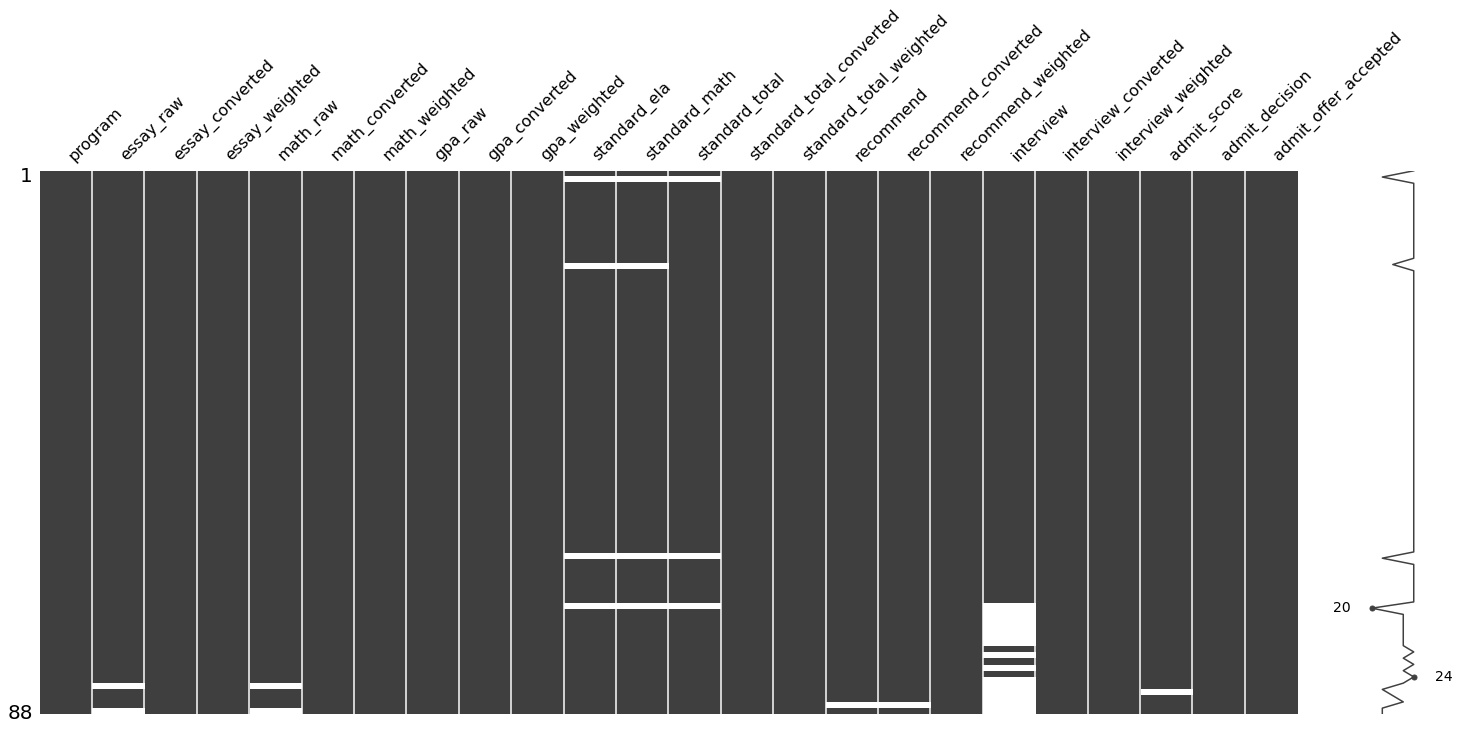

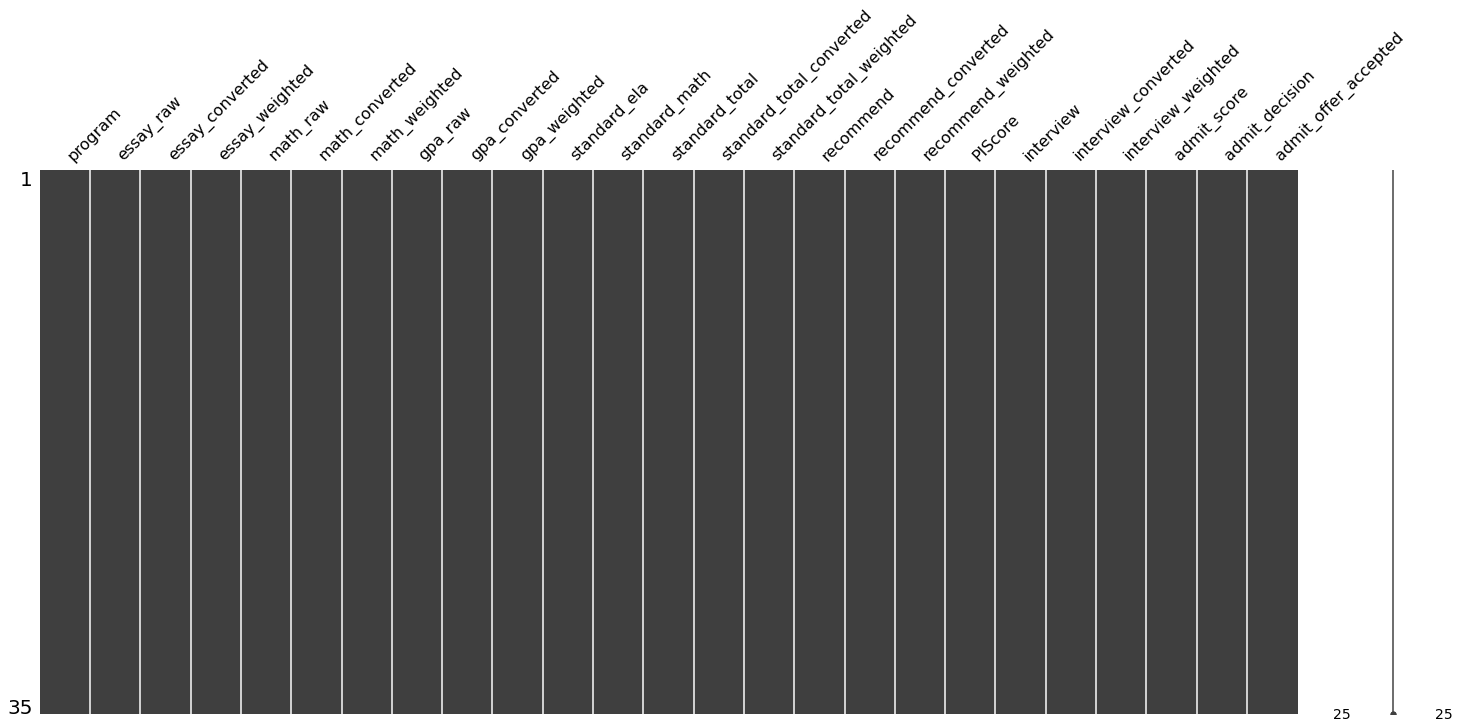

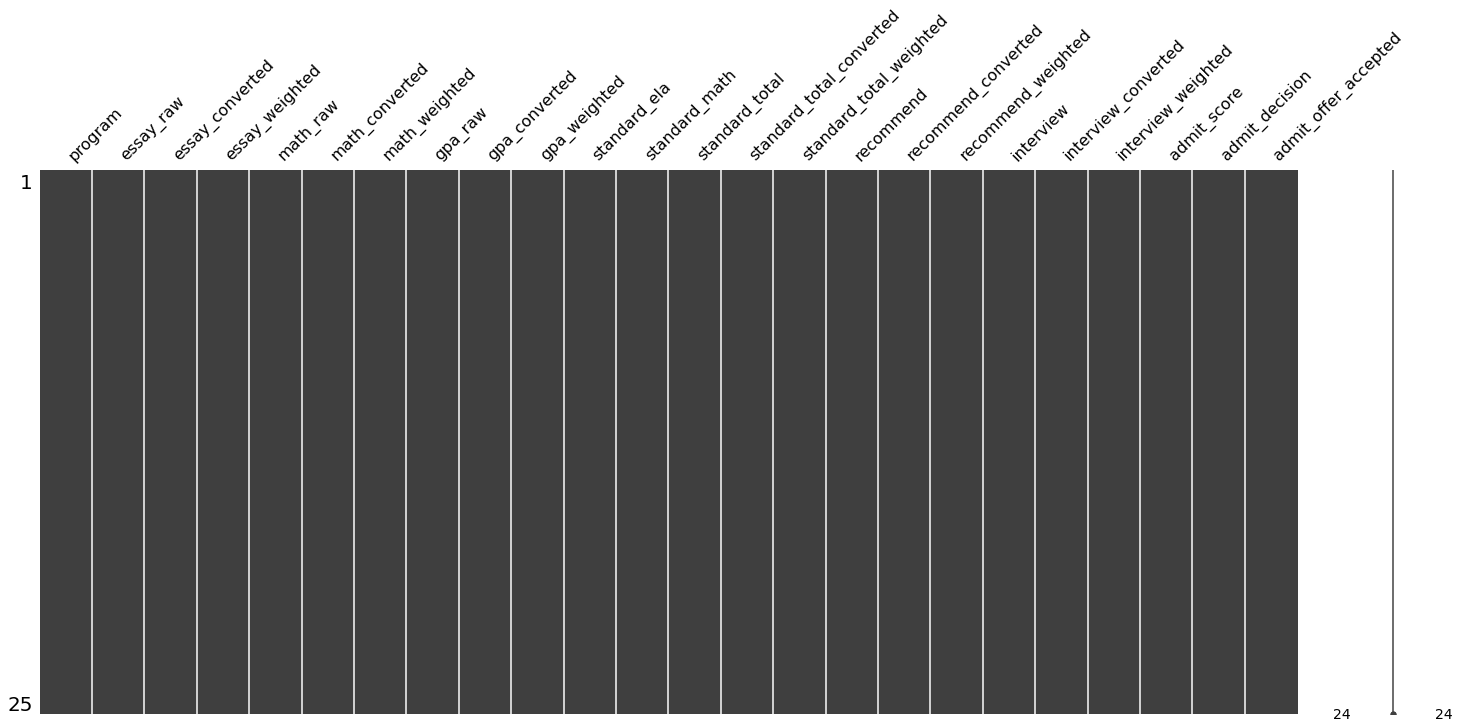

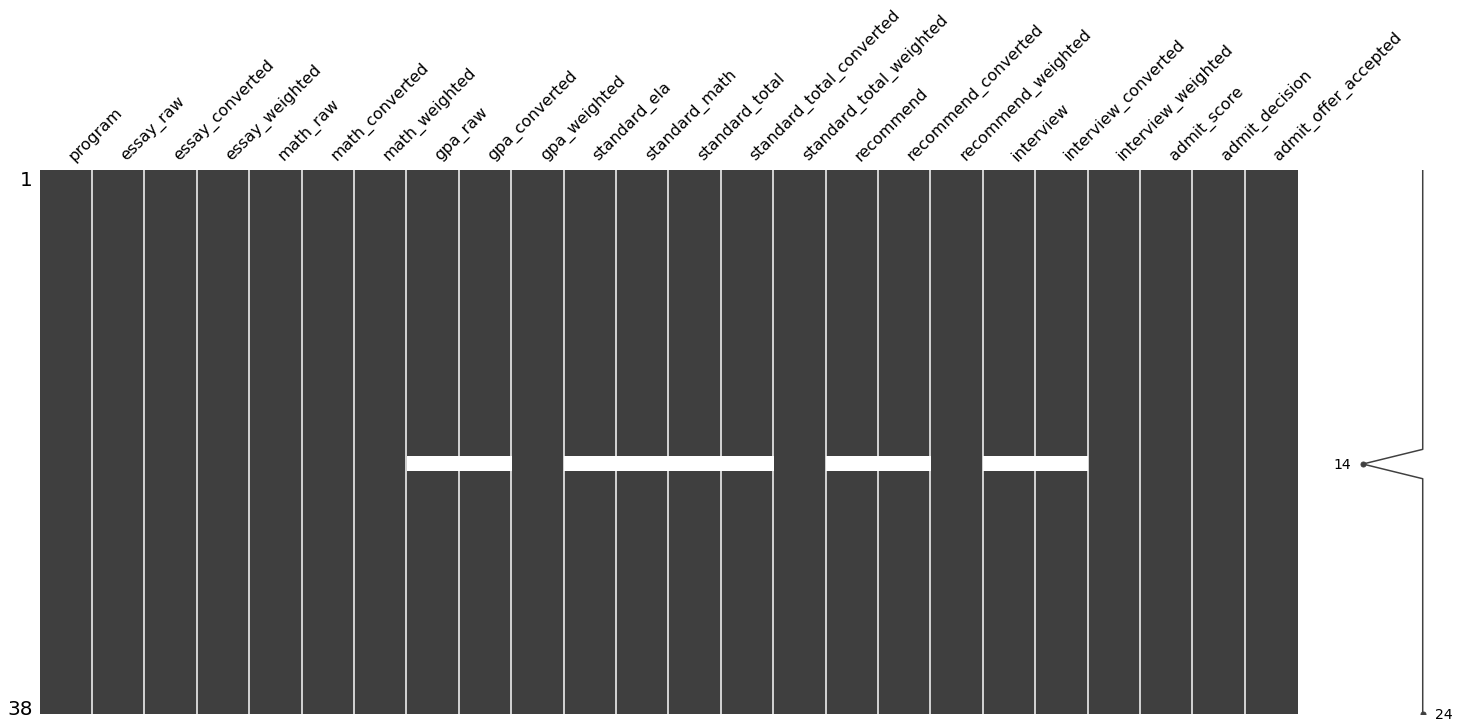

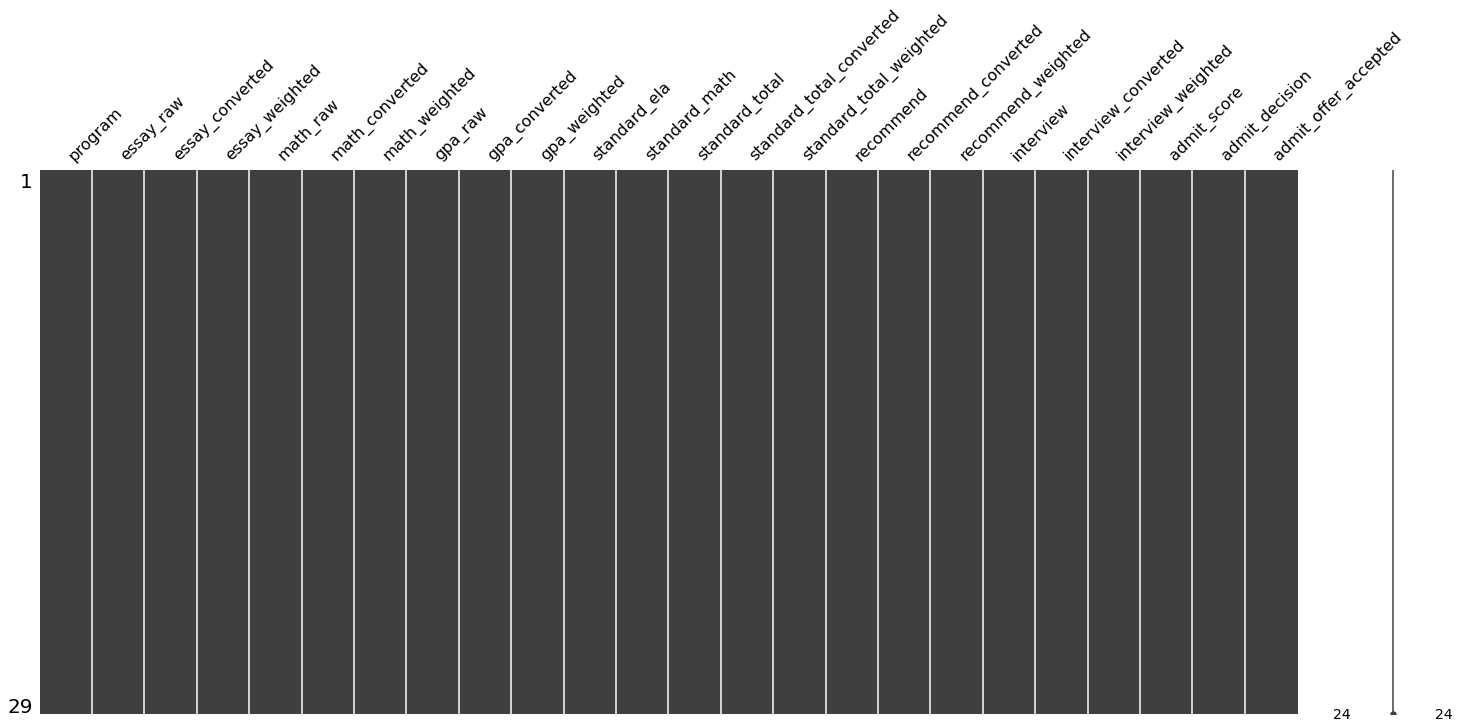

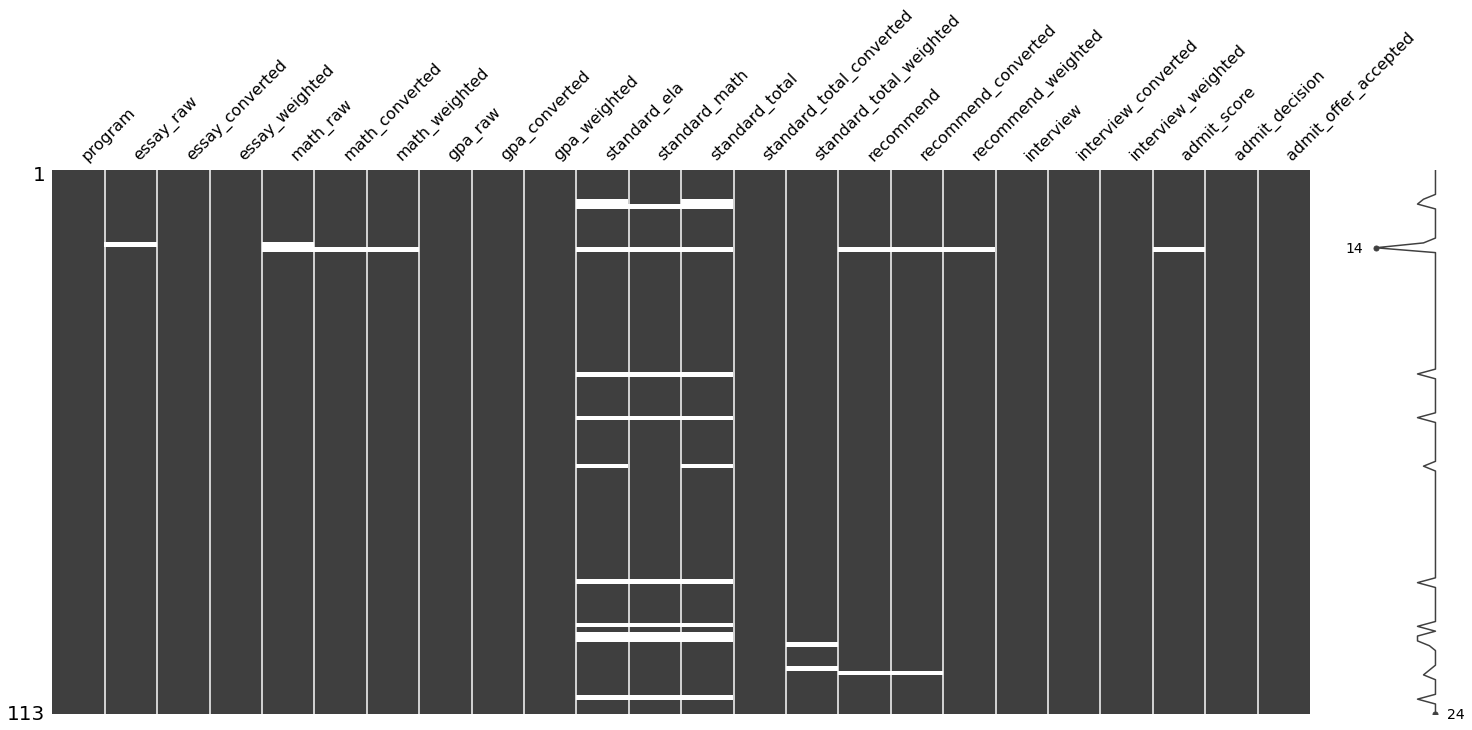

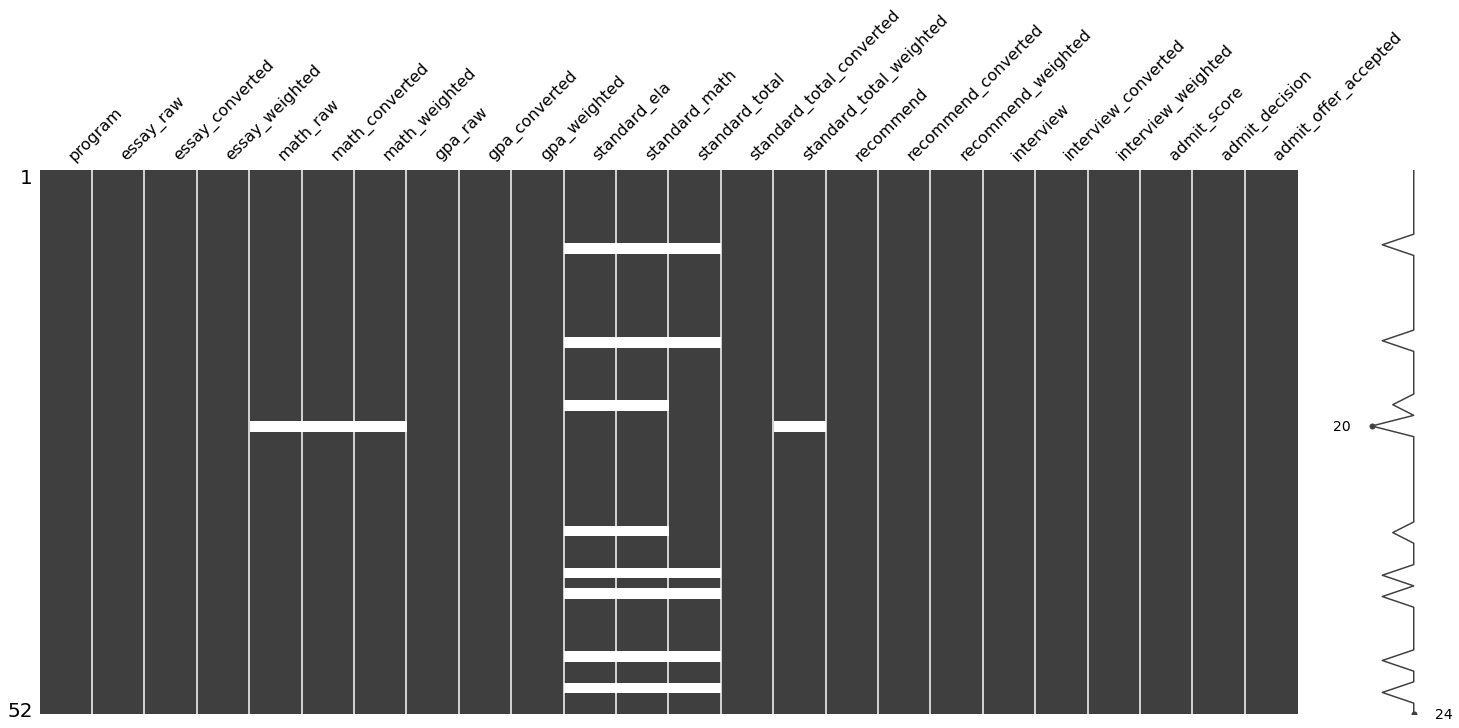

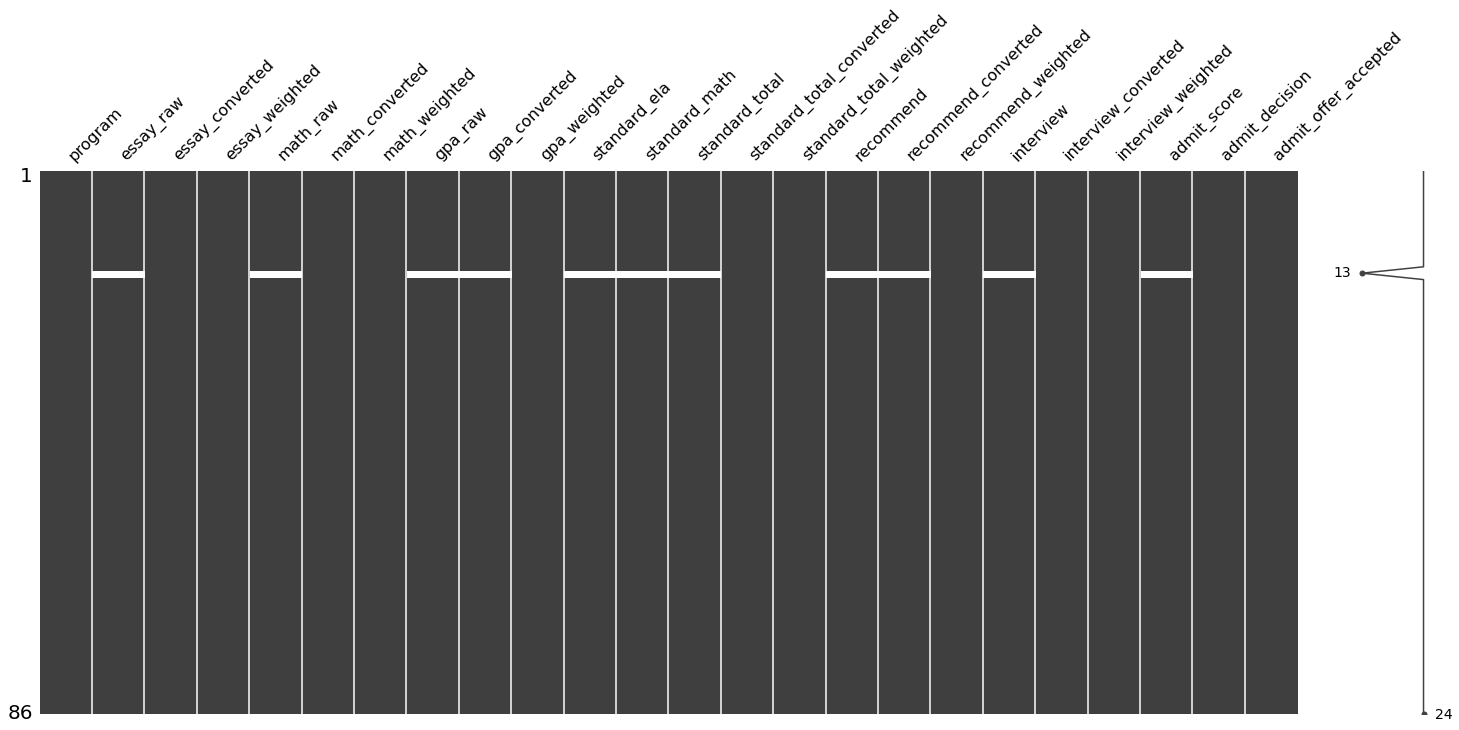

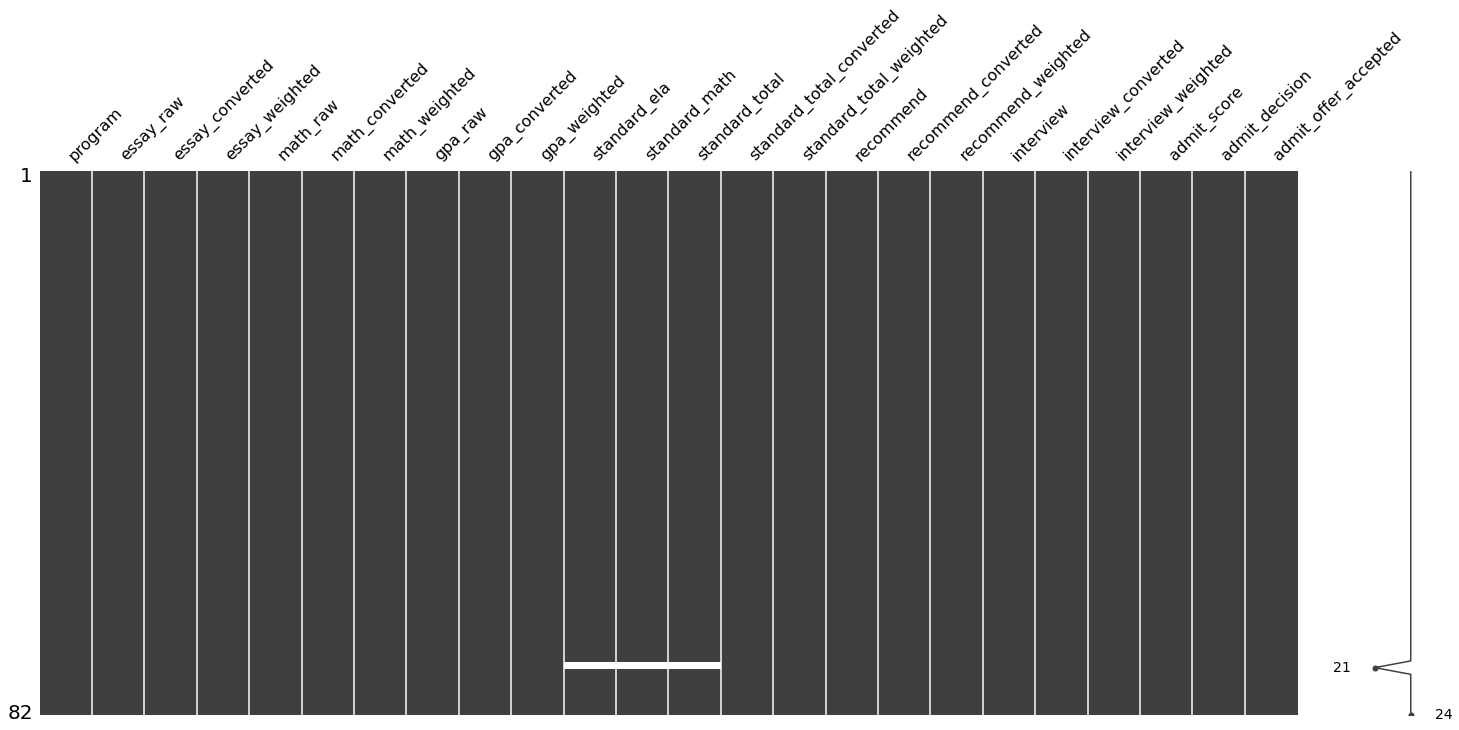

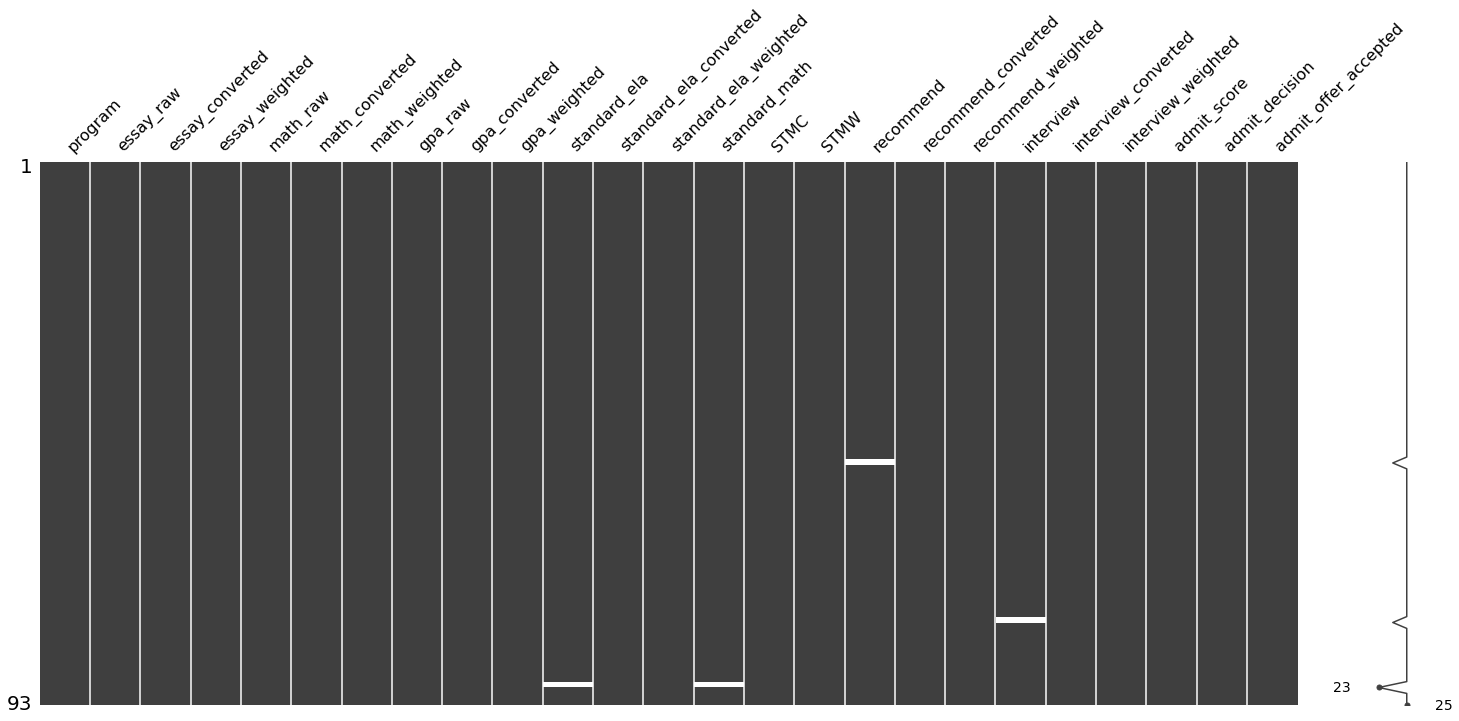

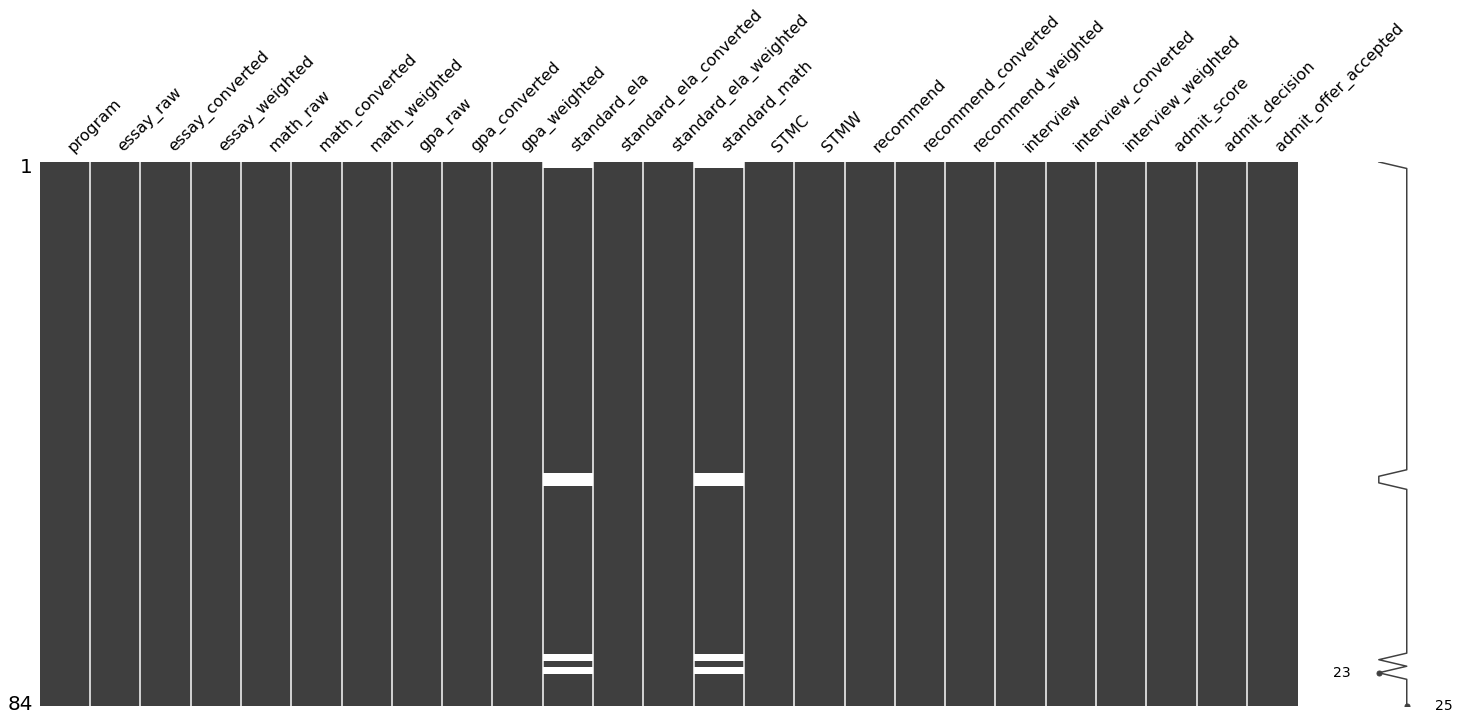

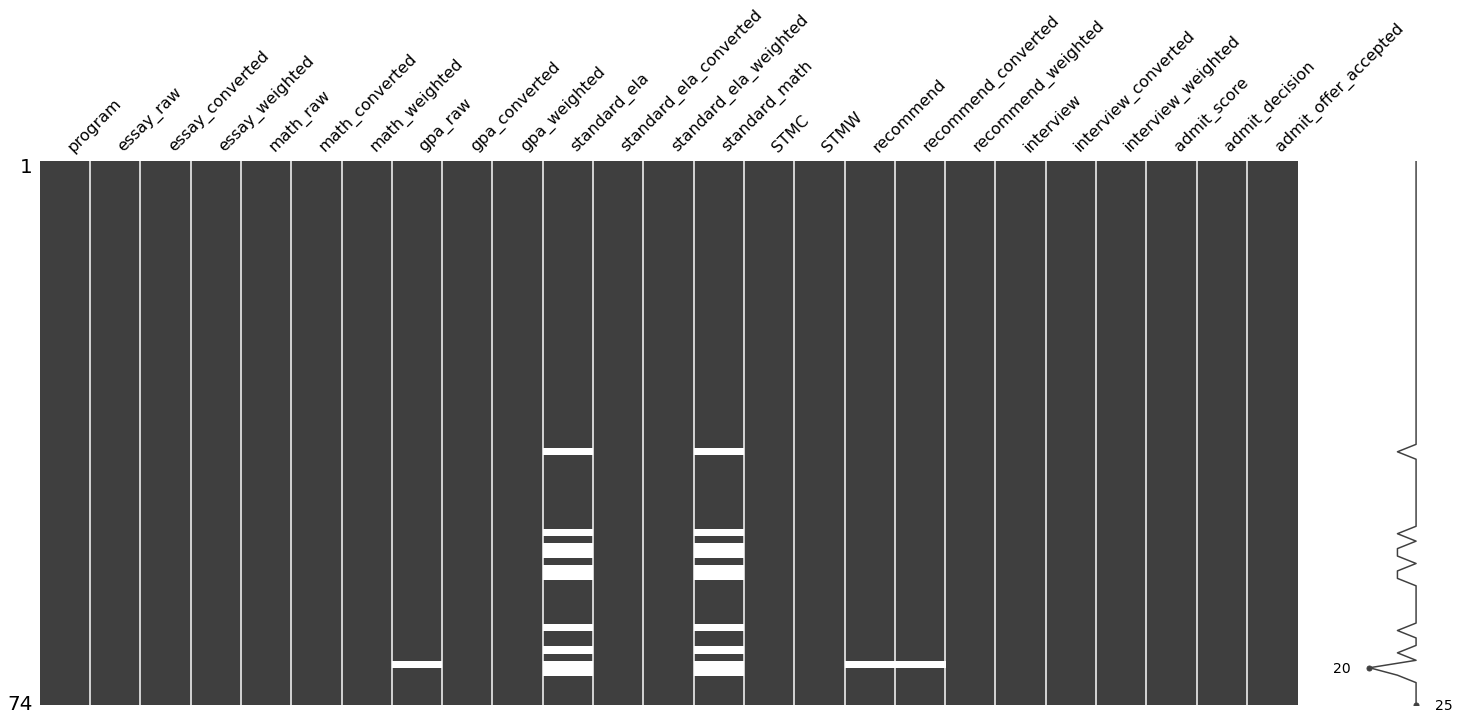

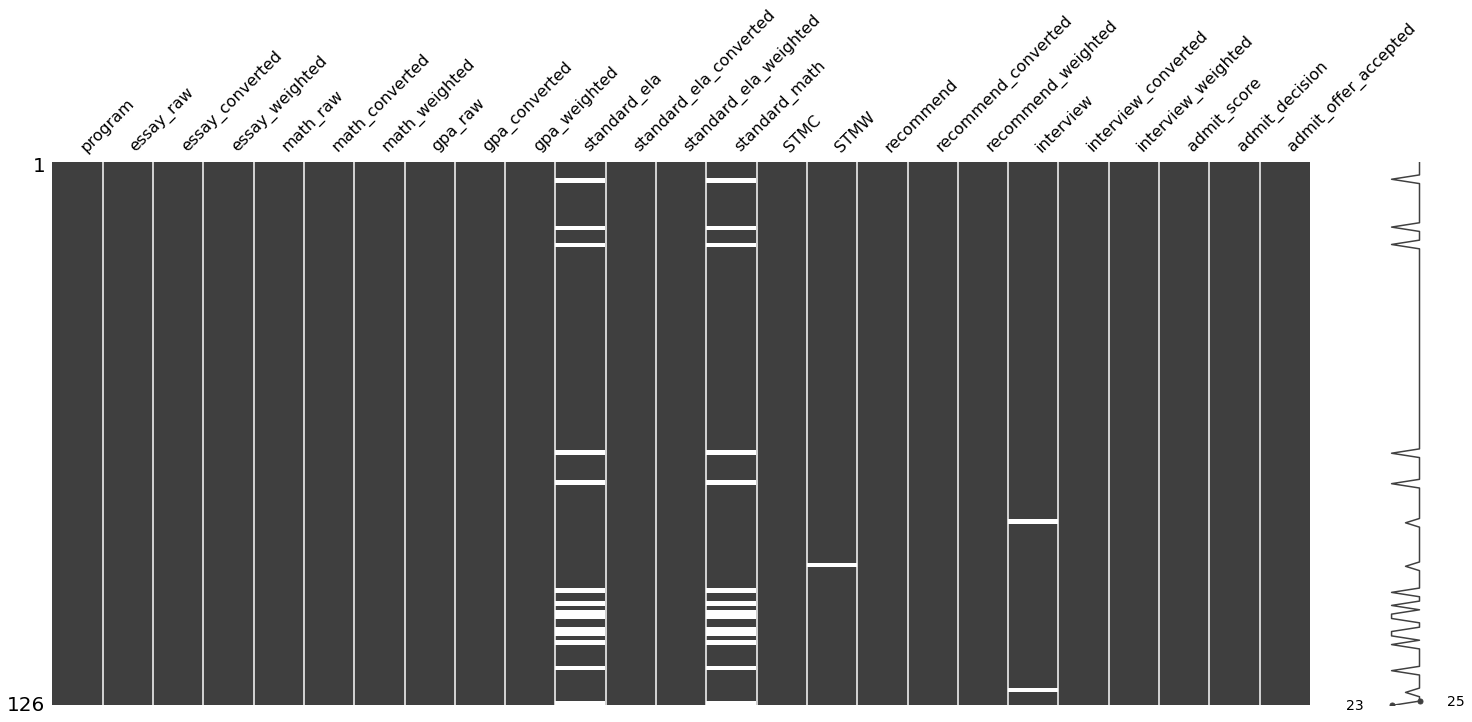

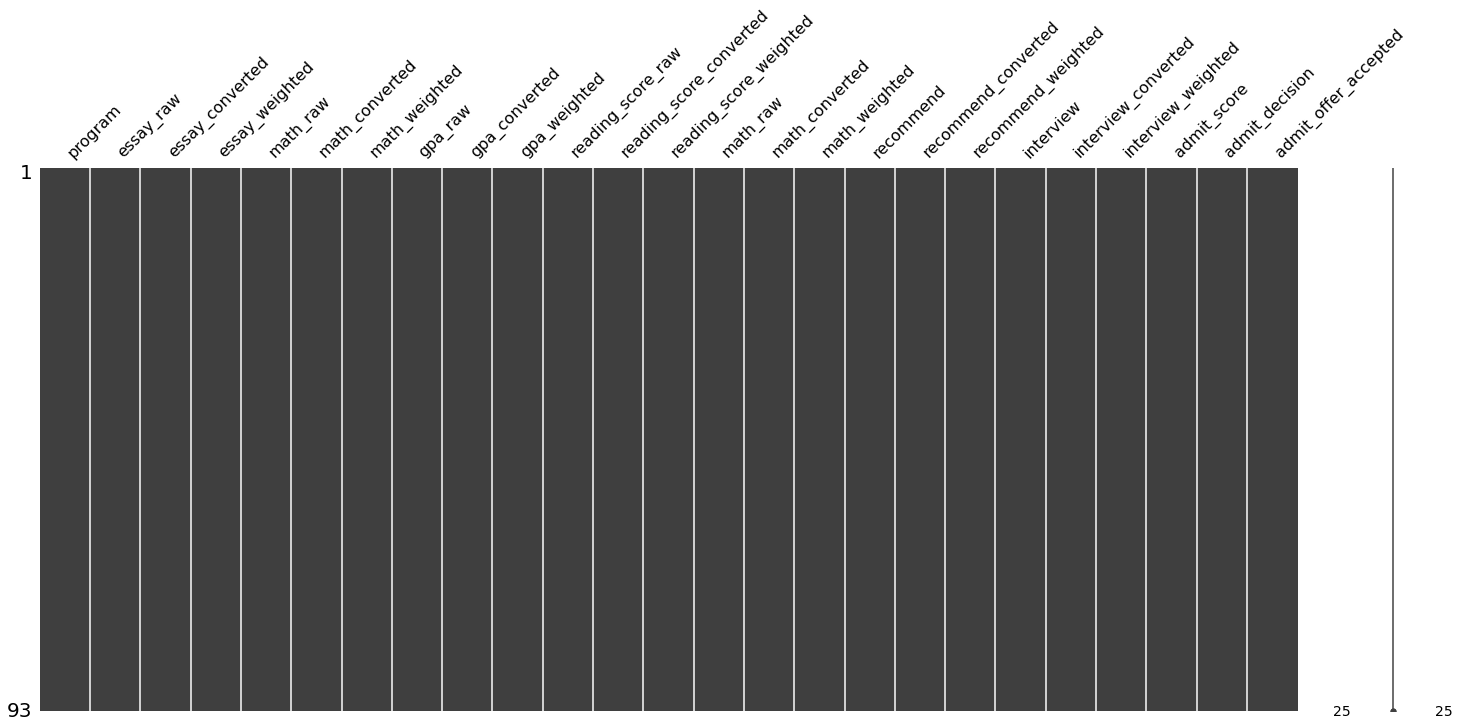

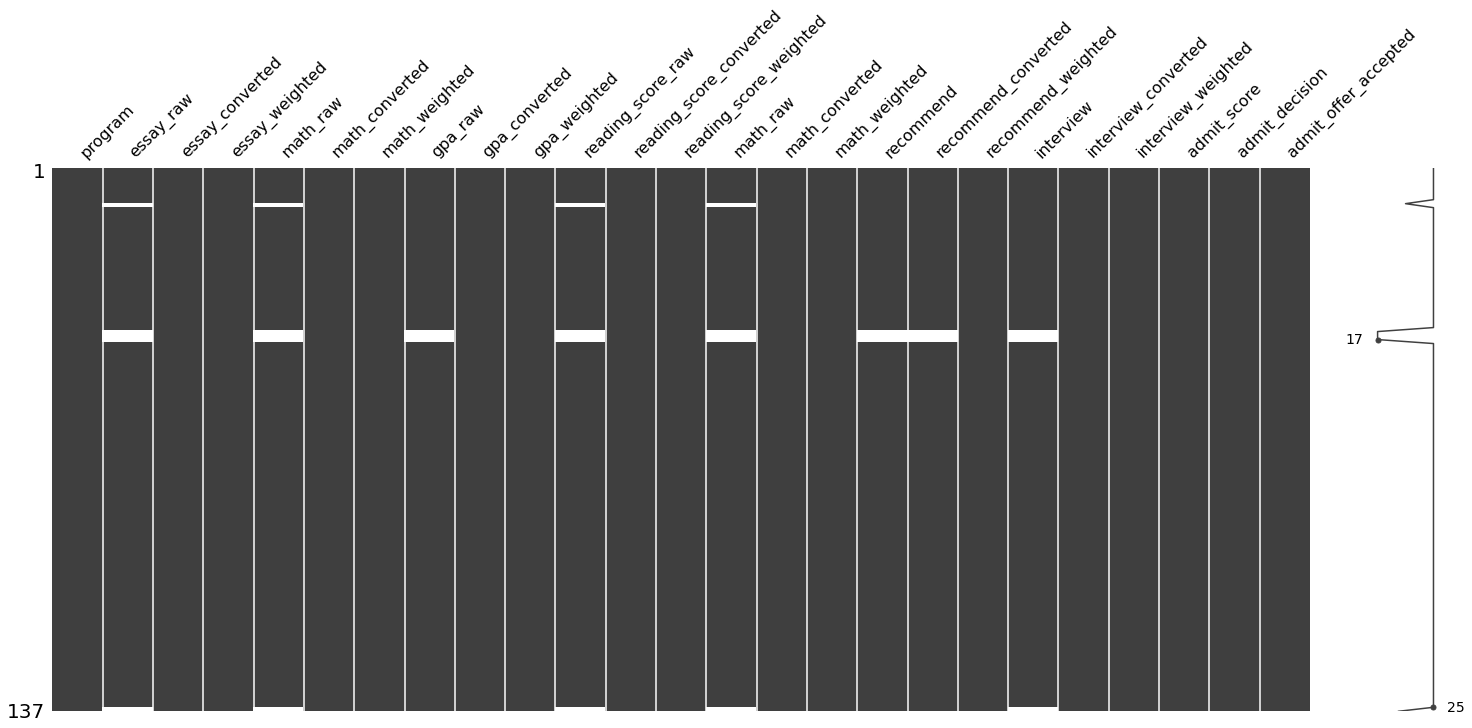

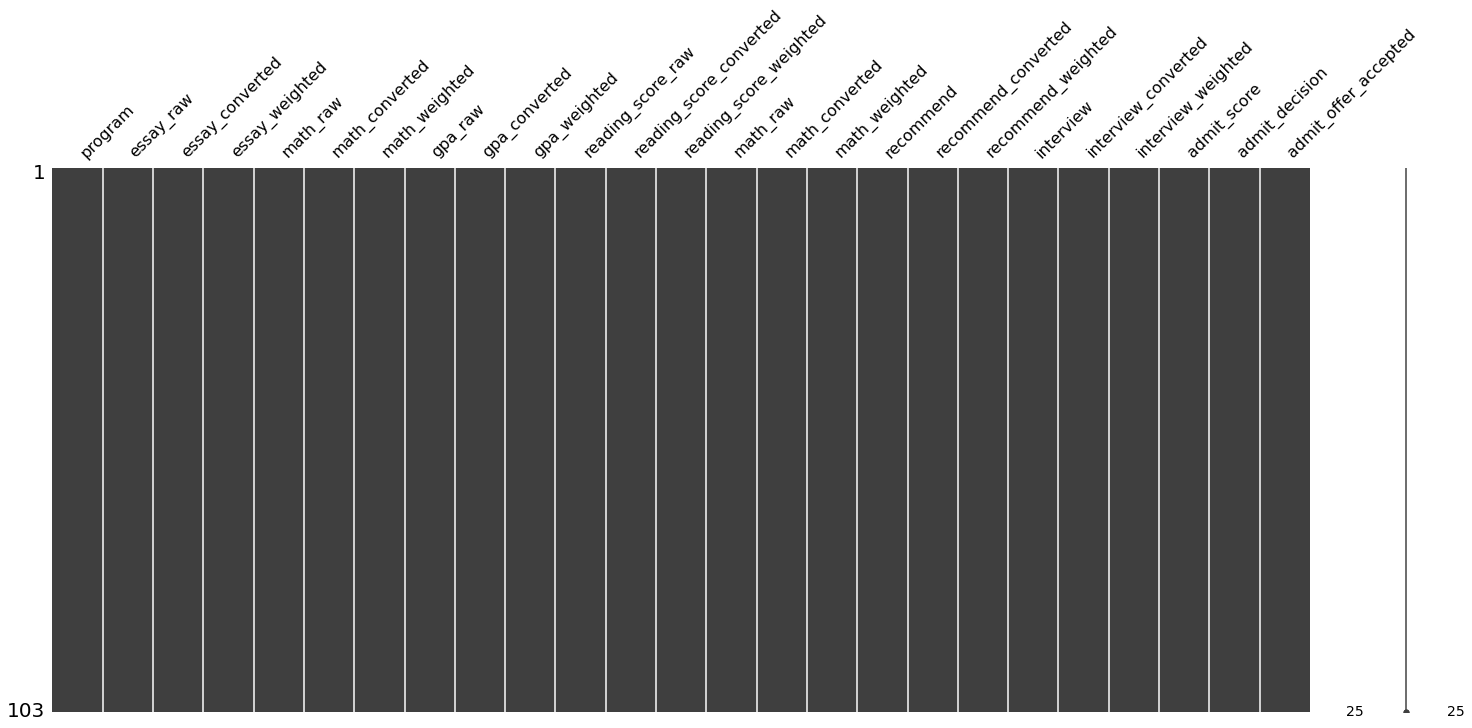

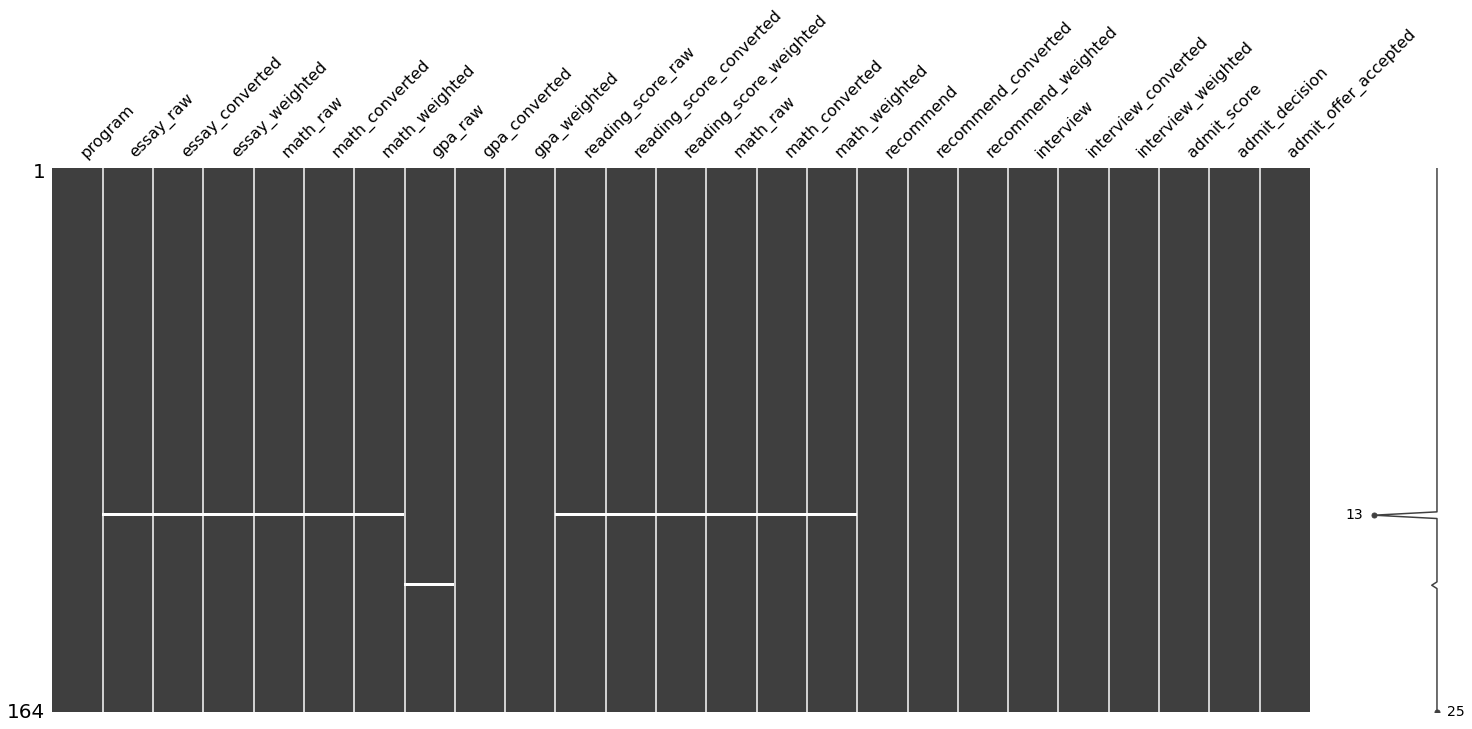

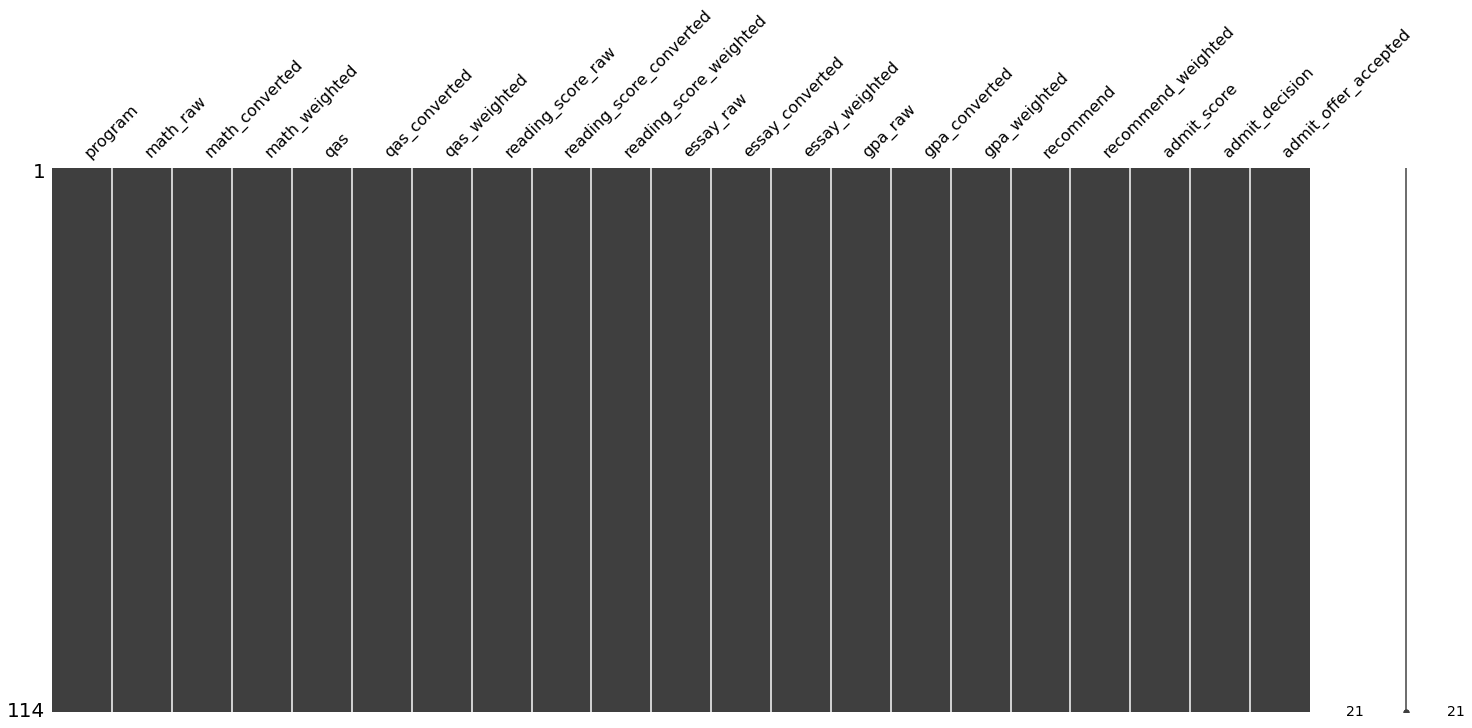

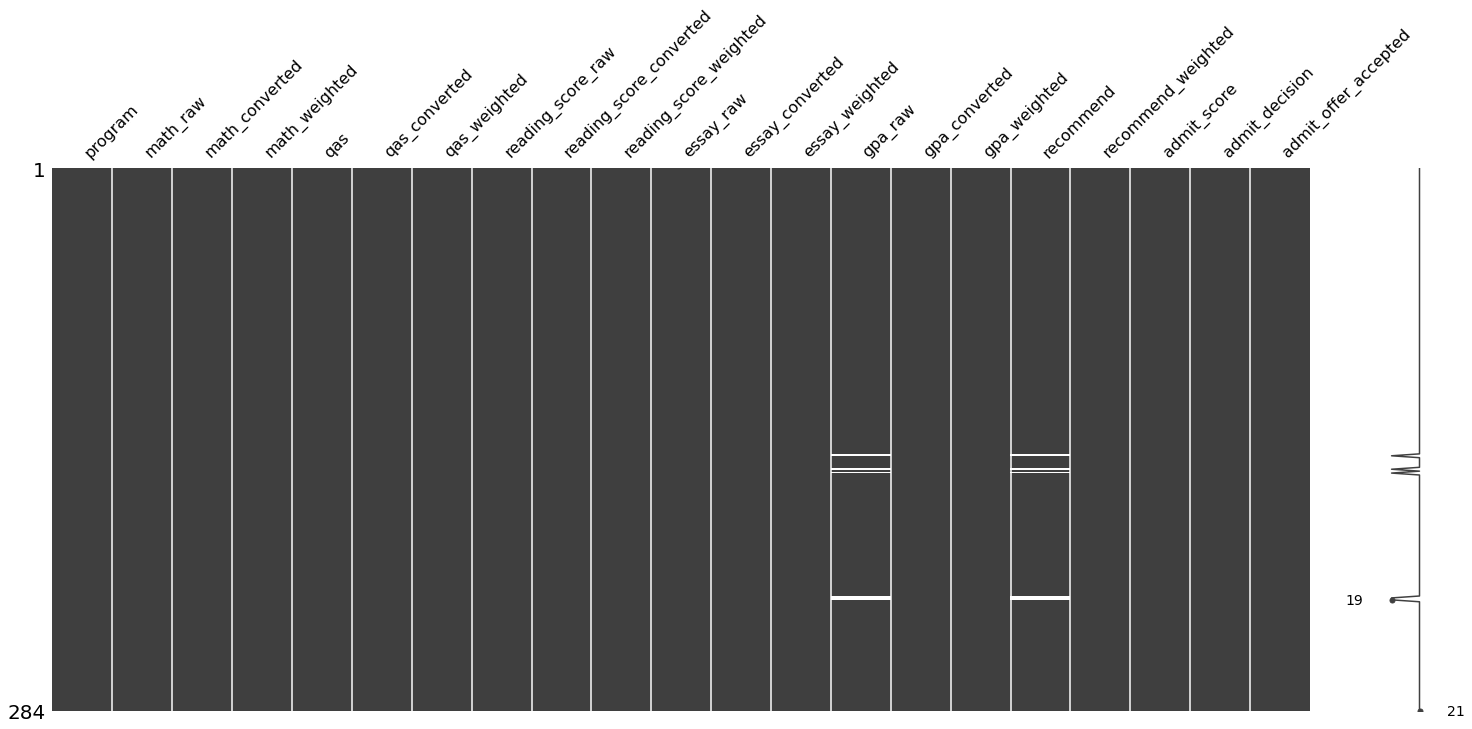

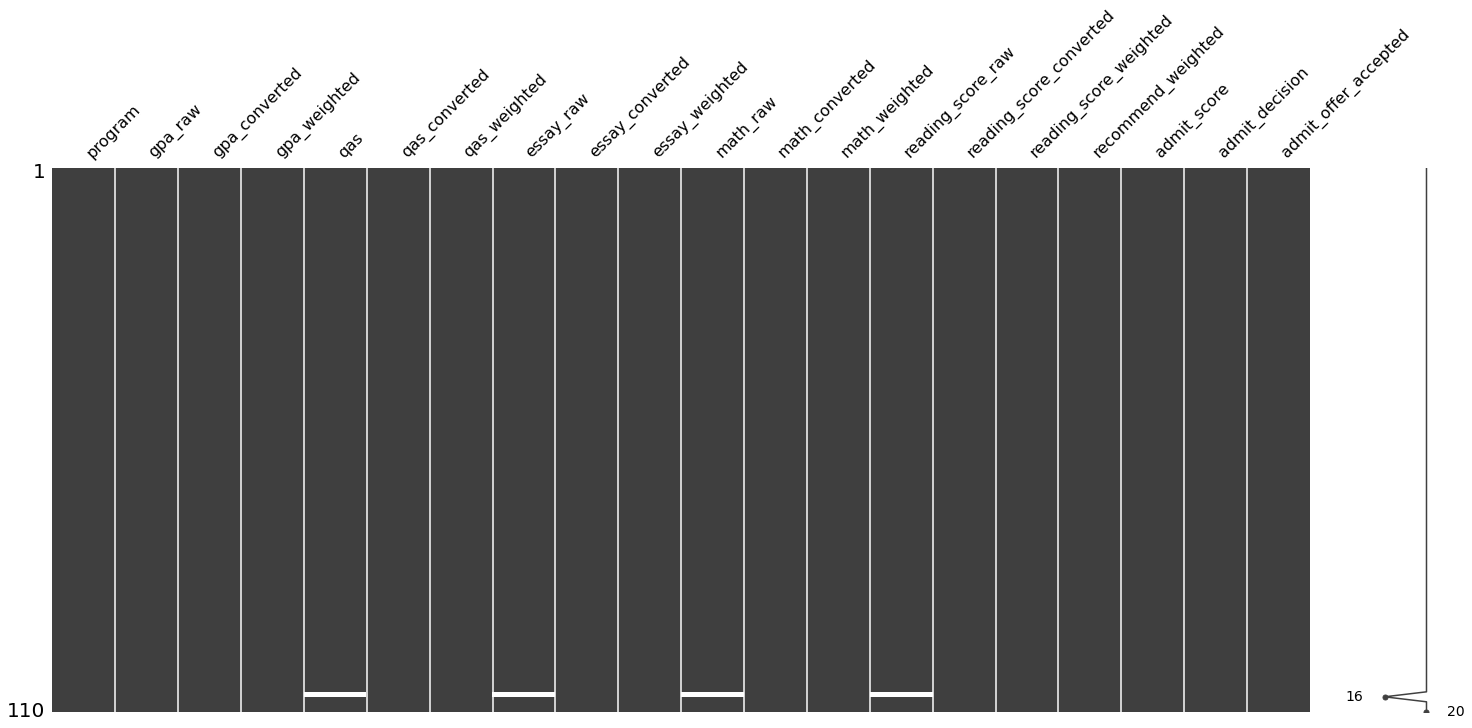

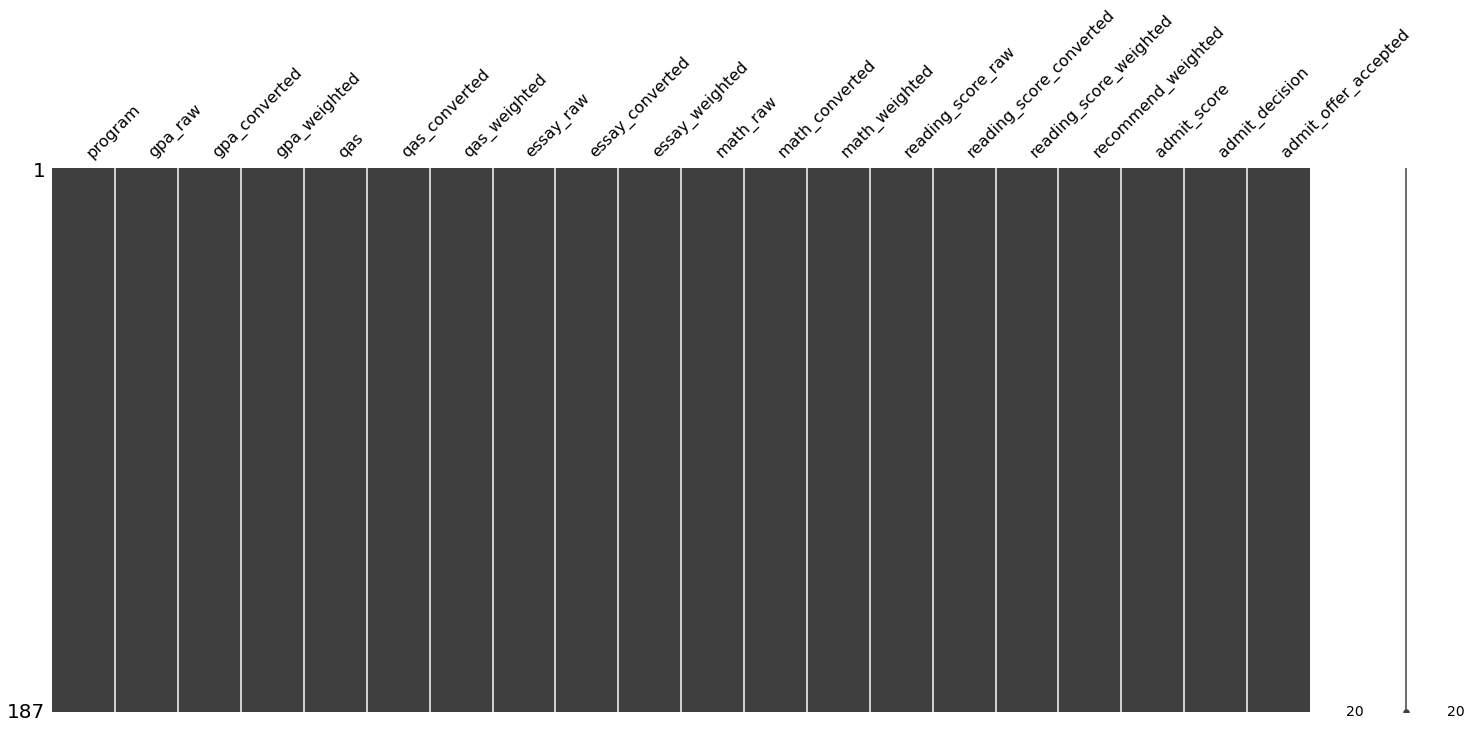

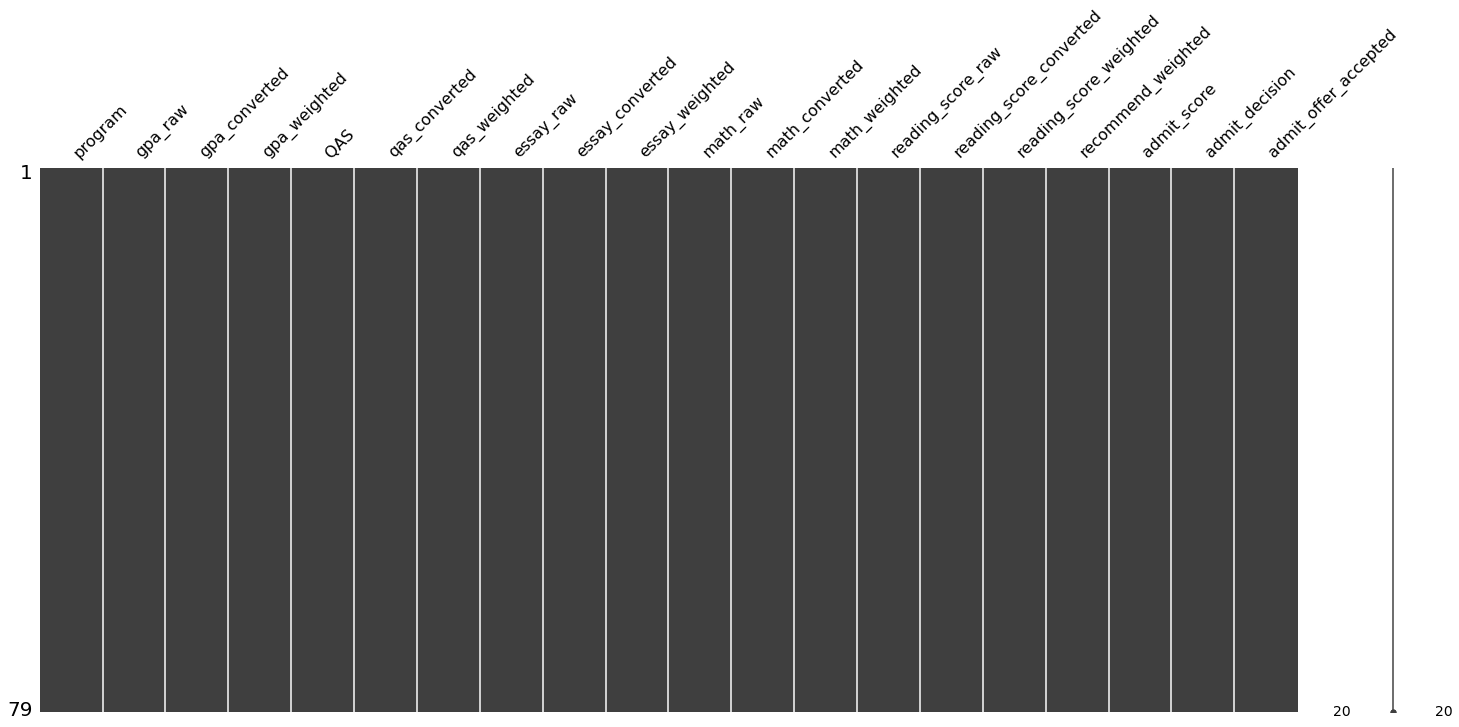

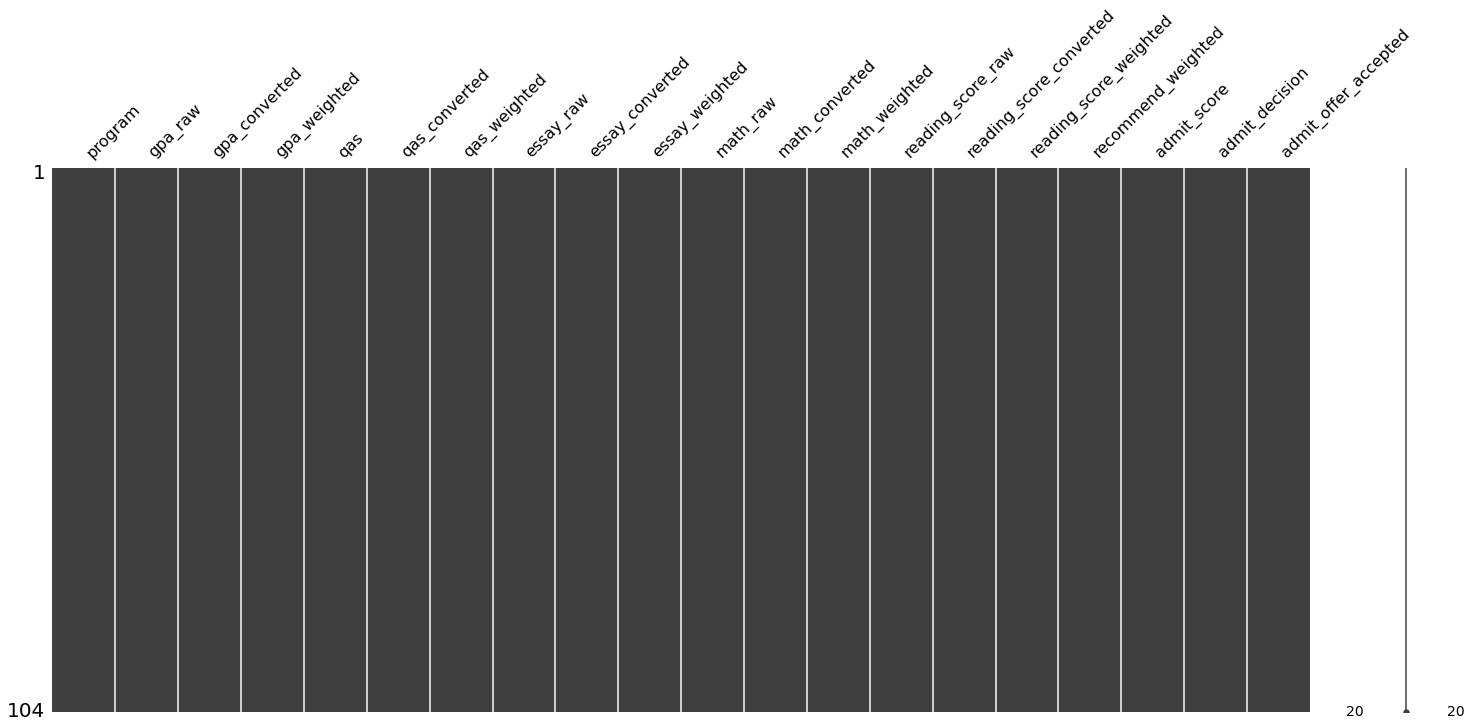

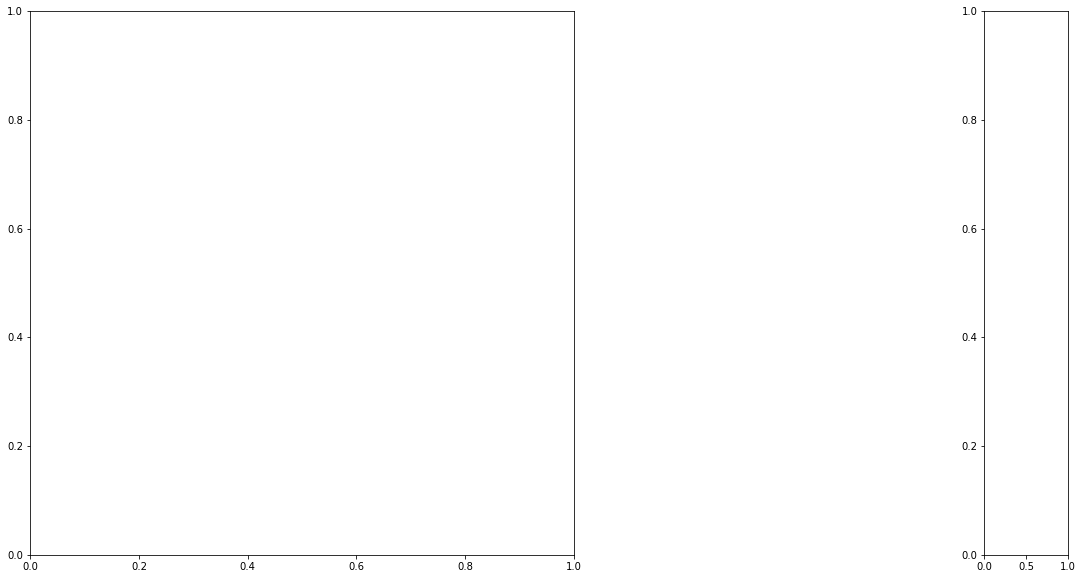

In [20]:
'''Visualize missing data'''
for key,item in var_dict.items():
    msno.matrix(item.sort_values('admit_decision'))

Given the low rate and nature of missingness, we are going to utilize MissForest imputation to fill missing values.  However, in order to prevent data leakage, this will be conducted within a pipeline when we are ready to build our model.

### In the following cells, the missing data in each dataframe will be imputed and standardized separately. This will be done since different dependent measures were utilized across years.  Each year will be imputed and standarized separately and then the dataframes will be concatanated.

In [21]:
'''Create list with only numeric variables'''
def transform_numeric (df):
    return df.select_dtypes(include="number").columns.tolist()

In [22]:
'''Create list with only categorical variables'''
def transform_categorical (df):
    return df.select_dtypes(include="object").columns.tolist()

In [23]:
'''Transformer for categorical features'''
cat_transform = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('ordinal_encoder', OrdinalEncoder()) 
    ]
)

In [24]:
'''Transformer for numerical features'''
num_transform = Pipeline(
    [
        ('imputer_num', MissForest()),
        ('scaler', StandardScaler())
    ]
)

In [25]:
num_cols = []
cat_cols = []

In [26]:
'''Combine transformers into ColumnTransformer'''
preprocessor = ColumnTransformer(
    [
        ('categorical', cat_transform, cat_cols),
        ('numerical', num_transform, num_cols)
    ],
    remainder = 'drop'
)

In [27]:
'''Define pipeline for data processing'''
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', MissForest())
    ],
    verbose=True
)

In [28]:
'''Define parameters dict to be used in GridSearchCV'''
params = {
    'clf__max_iter' : np.arange(2,3),
    'clf__criterion' : ['mse', 'gini'],
    'clf__min_samples_split' : np.arange(2, 10, 2),
    'clf__min_samples_leaf' : np.arange(1, 5)
    }

In [29]:
'''Create Randomized Grid Search'''
rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)

cv = RandomizedSearchCV(
    preprocessor, 
    params, 
    cv = 5, 
    scoring = ['accuracy'], 
    refit = 'accuracy',
    verbose = 3,
    #n_jobs = -1
  )

In [31]:
set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 []),
                                ('numerical',
                                 Pipeline(steps=[('imputer_num', MissForest()),
                                                 ('scaler', StandardScaler())]),
                                 [])])

In [32]:
'''Function to split training and testing datasets'''
def run_model(df, target):
    num_cols = transform_numeric(df)
    print(f'num_cols: {num_cols}')
    cat_cols = transform_categorical(df)
    print(f'cat_cols: {cat_cols}')
    
    X = df.drop(target, axis = 1)
    y = df[[target]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

    '''Fit Model'''
    cv.fit(X_train, y_train)

In [33]:
'''Run model'''
df2 = var_dict['df_2014_2015_in_district']
run_model(df2, 'program')

num_cols: ['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw', 'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted', 'gpa_weighted', 'standard_ela', 'standard_ela_converted', 'standard_ela_weighted', 'standard_math', 'STMC', 'STMW', 'recommend', 'recommend_converted', 'recommend_weighted', 'interview', 'interview_converted', 'interview_weighted', 'admit_score']
cat_cols: ['program', 'admit_decision', 'admit_offer_accepted']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clf__min_samples_split=8, clf__min_samples_leaf=2, clf__max_iter=2, clf__criterion=mse 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter clf for estimator ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 []),
                                ('numerical',
                                 Pipeline(steps=[('imputer_num', MissForest()),
                                                 ('scaler', StandardScaler())]),
                                 [])]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
df = var_dict['df_2014_2015_in_district']
num_cols = transform_numeric(df)
cat_cols = transform_categorical(df)

In [ ]:
imputer = MissForest()
df_num_cols = [col for col in num_cols if col in df.columns]
df_imputed = imputer.fit_transform(df[df_num_cols])
print(df_imputed)

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(df_scaled, columns = var_dict['df_2014_2015_in_district'][df_num_cols].columns)
df_scaled.info()

In [ ]:
df_scaled

In [ ]:
imputer = SimpleImputer(strategy = 'constant', fill_value = 'missing')
df_cat_cols = [col for col in cat_cols if col in df.columns]
df_imputed = imputer.fit_transform(df[df_cat_cols])
print(df_imputed[:5])

In [ ]:
encoder = OrdinalEncoder()
df_encoder = encoder.fit_transform(df_imputed)
print(df_encoder)

In [ ]:
       ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('ordinal_encoder', OrdinalEncoder()) 

In [ ]:
df_final = pd.DataFrame(df_scaled, columns = df.columns)
df_final

### Combining all dataframes into a single dataframe

In [ ]:
column_list = var_dict['df_2008_2009_ib_magnet'].columns.tolist()
for key, item in var_dict.items():
    for column in item.columns:
        if column not in column_list:
            column_list.append(column)
print(column_list)

for key, item in var_dict.items():
    for column in item.columns:
        if item in intersection(item.columns, column_list):
            item[column] = np.nan
    

In [ ]:
for key, item in var_dict.items():
    print(len(item.columns))

In [ ]:
'''Perform KNN imputation'''
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(X)
Xtrans = imputer.transform(X)